# The Hopf oscillator model

The Hopf model describes the complex-plane motion of membrane potentials x and y of a single neuronal population (or local brain area) with a pair of mutually coupled linear–nonlinear differential equations: when the bifurcation parameter a is negative the origin is a stable focus and the population remains silent, whereas for a>0 the origin loses stability and a limit cycle emerges, so the population oscillates persistently at frequency ω.

In [ ]:
import jax

import brainmass
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
brainstate.environ.set(dt=0.1 * u.ms)

## Single node simulation

The normal-form (supercritical) Hopf oscillator for a single node can be written in complex form as

$$
\frac{dz}{dt} = (a + i\,\omega) z - \beta \lvert z \rvert^2 z + I_{\text{ext}}(t),
$$

where $z = x + i y$ and $\lvert z \rvert^2 = x^2 + y^2$. In real coordinates $(x, y)$ this becomes

$$
\begin{aligned}
\dot x &= (a - \beta r) x - \omega y + I_x(t),\\
\dot y &= (a - \beta r) y + \omega x + I_y(t),\\
 r &= x^2 + y^2.
\end{aligned}
$$

- $a$ controls proximity to the Hopf bifurcation ($a=0$).
- $\omega$ sets the angular frequency (in this implementation, dimensionless).
- $\beta>0$ saturates the amplitude and sets the limit-cycle radius.
- $I_x, I_y$ collect any external inputs and noise terms.

Units: The right-hand sides return derivatives with unit $1/\text{ms}$ so that an explicit (exponential) Euler step with time step $dt$ in milliseconds is consistent with the `brainunit` unit system.


In [ ]:
node = brainmass.HopfOscillator(
    1,  # single node
    a=0.25,
    w=0.2,
    beta=1.0,
    noise_x=brainmass.OUProcess(1, sigma=0.01),
    noise_y=brainmass.OUProcess(1, sigma=0.01),
)

brainstate.nn.init_all_states(node)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        node.update()
        return node.x.value, node.y.value


indices = np.arange(10000)
x_trace, y_trace = brainstate.transform.for_loop(step_run, indices)

In [ ]:
t_ms = indices * brainstate.environ.get_dt()
plt.figure(figsize=(6, 3))
plt.plot(t_ms, x_trace[:, 0], label='x(t)')
plt.plot(t_ms, y_trace[:, 0], label='y(t)')
plt.xlabel('time (ms)')
plt.ylabel('Activity')
plt.title('Single Hopf oscillator with OU noise')
plt.legend()
plt.tight_layout()
plt.show()

## Bifurcation diagram

At the origin $(x,y)=(0,0)$ the linearization has eigenvalues $\lambda_{\pm} = a \pm i \omega$.

- For $a < 0$: the origin is a stable focus; trajectories spiral into $(0,0)$.
- For $a = 0$: a Hopf bifurcation occurs.
- For $a > 0$: the origin is unstable and a stable limit cycle of radius $\approx \sqrt{a/\beta}$ emerges (supercritical Hopf). The oscillation frequency is approximately $\omega$ near onset.

Increasing $\beta$ decreases the saturated amplitude while leaving the linear frequency set by $\omega$.


In [ ]:
a_vals = np.linspace(-2, 2, 50)  # 50 points

nodes = brainmass.HopfOscillator(
    a_vals.size,
    a=a_vals,  # 每个节点对应一个 a
    w=0.2,
    beta=1.0,
    init_x=braintools.init.Uniform(0, 1),
    init_y=braintools.init.Uniform(0, 1),
)
brainstate.nn.init_all_states(nodes)


def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return nodes.update()


indices = np.arange(20000)
x_trace = brainstate.transform.for_loop(step_run, indices)
x_last = x_trace[-5000:]  # shape (5000, 50)
max_x = x_last.max(axis=0)
min_x = x_last.min(axis=0)

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(a_vals, max_x, c='k', lw=2, label='max x')
plt.plot(a_vals, min_x, c='k', lw=2, label='min x')
plt.axvline(0.0, ls='--', color='gray')
plt.title('Hopf bifurcation diagram')
plt.xlabel('bifurcation parameter a')
plt.ylabel('max / min x')
plt.legend()
plt.tight_layout()
plt.show()

## Brain network

For $N$ nodes with states $(x_i, y_i)$ one convenient diffusive coupling is

$$
\begin{aligned}
\dot x_i &= (a - \beta r_i) x_i - \omega y_i \; + \; K \sum_{j} W_{ij} (x_j - x_i) + I_i^x(t),\\
\dot y_i &= (a - \beta r_i) y_i + \omega x_i \; + \; K \sum_{j} W_{ij} (y_j - y_i) + I_i^y(t),\\
 r_i &= x_i^2 + y_i^2,
\end{aligned}
$$

where $W$ is a connectivity matrix and $K$ a global coupling gain. In BrainMass this can be assembled using the coupling helpers (`DiffusiveCoupling` or `diffusive_coupling`) by prefetching node states and applying the kernel per component.

An alternative is to couple in the complex form, $z_i = x_i + i y_i$, using a linear term $K \sum_j W_{ij} (z_j - z_i)$; real and imaginary parts yield the two equations above.

Relation to Kuramoto: In the limit of strongly attracting amplitudes (large $\beta$ and $a>0$), the dynamics reduce approximately to phase-only coupling (Kuramoto-type) on the emergent limit cycle.


Load the human connectome project sample data from Kaggle.

In [ ]:
import os.path
import kagglehub
path = kagglehub.dataset_download("oujago/hcp-gw-data-samples")
data = braintools.file.msgpack_load(os.path.join(path, "hcp-data-sample.msgpack"))

In [8]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2.):
        super().__init__()

        # connection weight
        conn_weight = data['Cmat'].copy()
        np.fill_diagonal(conn_weight, 0)
        self.conn_weight = conn_weight

        # delay information
        delay_time = data['Dmat'].copy() / signal_speed
        np.fill_diagonal(delay_time, 0)
        delay_time = delay_time * u.ms
        indices_ = np.expand_dims(np.arange(conn_weight.shape[1]), 0)
        indices_ = np.repeat(indices_, conn_weight.shape[0], axis=0)
        delay_index = (delay_time, indices_)

        # nodes
        n_node = conn_weight.shape[1]
        self.n_node = n_node
        self.node = brainmass.HopfOscillator(
            n_node,
            w=1.0,
            a=0.25,
            init_x=braintools.init.Uniform(0, 0.5),
            init_y=braintools.init.Uniform(0, 0.5),
            noise_x=brainmass.OUProcess(n_node, sigma=0.14, tau=5.0 * u.ms),
            noise_y=brainmass.OUProcess(n_node, sigma=0.14, tau=5.0 * u.ms),
        )

        # couplings
        self.coupling_x = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('x', delay_index, init=braintools.init.Uniform(0, 0.05)),
            self.node.prefetch('x'),
            conn_weight,
            k=1.0
        )

    def update(self):
        self.node.update(x_inp=self.coupling_x())
        return self.node.x.value, self.node.y.value

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

In [9]:
# Run the simulation
dt = brainstate.environ.get_dt()
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, int(0.5 * u.second // dt))

exes_tuple = brainstate.transform.for_loop(net.step_run, indices)
exes_x = jax.block_until_ready(exes_tuple[0])
exes_y = jax.block_until_ready(exes_tuple[1])

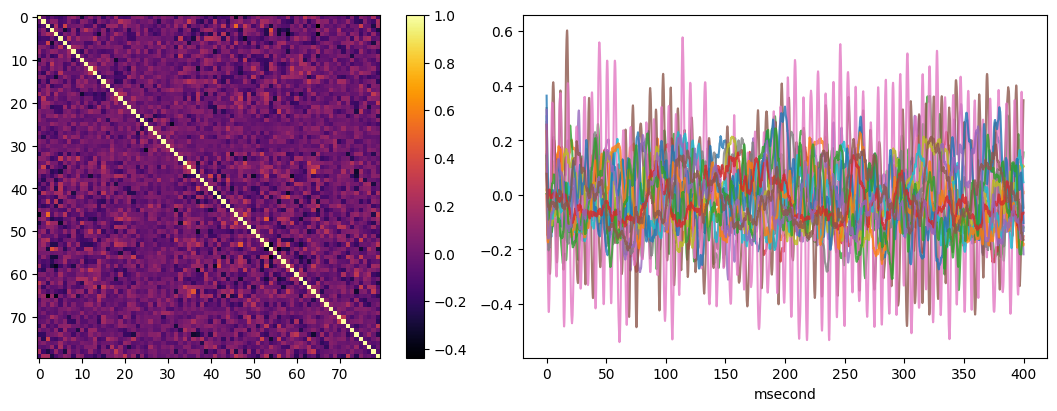

In [13]:
# Visualization
plt.rcParams['image.cmap'] = 'inferno'
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes_x)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices * dt, exes_x[:, ::5], alpha=0.8)
plt.show()